# UNET SEMANTIC SEGMENTATION of *Liriomyza spp.* on tomato leaves
## Transfer Learning using various architectures and backbones

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Instalar pacotes

In [ ]:
pip install -U segmentation-models

In [ ]:
pip install tensorflow

In [ ]:
!apt-get install python3.7

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3.7 is already the newest version (3.7.12-1+bionic1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


Verificar configuração do computador conectado


In [ ]:
from psutil import *

In [ ]:
print("Número de cores disponível: ", cpu_count())

#Modelo e velocidade da CPU:
!lscpu |grep 'Model name'

#Memória física disponível: 
!df -h / | awk '{print $4}' 

#Modelo da GPU:
!nvidia-smi -L 

#Especificação da GPU:
!nvidia-smi

Número de cores disponível:  4
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Avail
125G
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-a47c8bba-2a59-72ac-fc7a-a5f1f43882b3)
Tue Feb  1 19:22:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A

Importar bibliotecas

In [ ]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import random
import keras
import tensorflow
from matplotlib import pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
import segmentation_models as sm
#from keras.utils import normalize
#from tensorflow.python.keras.utils import normalize
from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import get_file

Segmentation Models: using `keras` framework.


In [ ]:
!python --version
print(keras.__version__)
print(tensorflow.__version__)

Python 3.7.12
2.7.0
2.7.0


Parâmetros de entrada

In [ ]:
SIZE_X = 256
SIZE_Y = 256
n_classes=3 

# Leitura de dados

In [ ]:
train_images_names = glob.glob('/content/drive/MyDrive/DB_mosca_minadora/train/train_images_patches_filtrado/*.png')
train_images_names.sort()
train_images = [cv2.imread(image,1) for image in train_images_names]
train_images = np.array(train_images)

In [ ]:
test_images_names = glob.glob('/content/drive/MyDrive/DB_mosca_minadora/test/test_images_patches_filtrado/*.png')
test_images_names.sort()
test_images = [cv2.imread(image,1) for image in test_images_names]
test_images = np.array(test_images)


In [ ]:
train_masks_names = glob.glob('/content/drive/MyDrive/DB_mosca_minadora/train/train_masks_patches_filtrado/*.png')
train_masks_names.sort()
train_masks = [cv2.imread(mask,0) for mask in train_masks_names]
train_masks = np.array(train_masks)

In [ ]:
test_masks_names = glob.glob('/content/drive/MyDrive/DB_mosca_minadora/test/test_masks_patches_filtrado/*.png')
test_masks_names.sort()
test_masks = [cv2.imread(mask,0) for mask in test_masks_names]
test_masks = np.array(test_masks)

Checkpoint

In [ ]:
print ("Train Image data shape:", train_images.shape)
print ("Test Image data shape:", test_images.shape)
print ("Train Mask data shape:", train_masks.shape)
print ("Train Mask data shape:", test_masks.shape)
print ("Max pixel valeue in train image:", train_images.max())
print ("Max pixel valeue in test image:", test_images.max())
print ("Max pixel valeue in train mask:", train_masks.max())
print ("Max pixel valeue in test mask:", test_masks.max())
print ("Labels in train masks:", np.unique(train_masks))
print ("Labels in test masks:", np.unique(test_masks))

Train Image data shape: (1628, 256, 256, 3)
Test Image data shape: (304, 256, 256, 3)
Train Mask data shape: (1628, 256, 256)
Train Mask data shape: (304, 256, 256)
Max pixel valeue in train image: 255
Max pixel valeue in test image: 255
Max pixel valeue in train mask: 75
Max pixel valeue in test mask: 75
Labels in train masks: [ 0 38 75]
Labels in test masks: [ 0 38 75]


## Codificar legendas

In [ ]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder() # só funciona em vetor unico e temos 3 dimensoes, com isso faz reshape no vetor
n, h, w = train_masks.shape # separar dimensões do formato da mascara #numero de bandas, altura e largura
train_masks_reshaped = train_masks.reshape(-1,1) # reshape para? (para normalizar)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped) # transformar e adequar, reencoda tudo
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w) # 

np.unique(train_masks_encoded_original_shape) # mostrar legendas das mascaras

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2])

In [ ]:
labelencoder = LabelEncoder() # só funciona em vetor unico e temos 3 dimensoes, com isso faz reshape no vetor
n, h, w = test_masks.shape # separar dimensões do formato da mascara #numero de bandas, altura e largura
test_masks_reshaped = test_masks.reshape(-1,1) # reshape para? (para normalizar)
test_masks_reshaped_encoded = labelencoder.fit_transform(test_masks_reshaped) # transformar e adequar, reencoda tudo
test_masks_encoded_original_shape = test_masks_reshaped_encoded.reshape(n, h, w) # 

np.unique(test_masks_encoded_original_shape) # mostrar legendas das mascaras

NameError: ignored

## Normalizar lista com imagens e Expandir dimensões das máscaras

In [ ]:
from tensorflow.keras.utils import normalize
from skimage import exposure, img_as_ubyte

#train_images = np.expand_dims(train_images, axis=3) # expandir dimensão de uma banda no fim # pulei esta, pois estava perdendo info das bandas
#train_images = normalize(train_images, axis=1) # normalizar para que o valor maximo de pixels seja 255

train_images = img_as_ubyte(exposure.rescale_intensity(train_images))

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3) # expandir dimensão das mascaras..
# (256,256) -> (256,256,1) - np.expand_dims(x, axis = -1)

print (train_masks_input.shape)
print (train_images.shape)
print ("Max pixel valeue in train images:", train_images.max())
print ("Max pixel valeue in train masks:", test_masks_encoded_original_shape.max())
print ("Type of train images:", train_images.dtype)
print ("Type of train maks:", train_masks.dtype)

(1628, 256, 256, 1)
(1628, 256, 256, 3)
Max pixel valeue in train images: 255
Max pixel valeue in train masks: 2
Type of train images: uint8
Type of train maks: uint8


In [ ]:
#train_images = np.expand_dims(train_images, axis=3) # expandir dimensão de uma banda no fim # pulei esta, pois estava perdendo info das bandas
#test_images = normalize(test_images, axis=1) # normalizar para que o valor maximo de pixels seja 255

test_images = img_as_ubyte(exposure.rescale_intensity(test_images))

test_masks_input = np.expand_dims(test_masks_encoded_original_shape, axis=3) # expandir dimensão das mascaras..
# (256,256) -> (256,256,1) - np.expand_dims(x, axis = -1)

print (test_masks_input.shape)
print (test_images.shape)
print ("Max pixel valeue in test images:", test_images.max())
print ("Max pixel valeue in test masks:", test_masks.max())
print ("Type of test images:", test_images.dtype)
print ("Type of test masks:", test_masks.dtype)

(304, 256, 256, 1)
(304, 256, 256, 3)
Max pixel valeue in test images: 255
Max pixel valeue in test masks: 75
Type of test images: uint8
Type of test masks: uint8


## Checkpoint tamanho DB

In [ ]:
print("Test Images DB Size:", len(test_images))
print("Test Masks DB Size:", len(test_masks_input))
print("Train Images DB Size:", len(train_images))
print("Train Masks DB Size:", len(train_masks_input))

Test Images DB Size: 304
Test Masks DB Size: 304
Train Images DB Size: 1628
Train Masks DB Size: 1628


## Definir X e Y teste e treinamento

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images,train_masks_input, test_size = 0.10, random_state = 0)

In [ ]:
print("Training data: ", len(X_train))
print("Testing data: ", len(X_val))

Training data:  1465
Testing data:  163


Categorizar

In [ ]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes)) # rodar também sem esta linha


test_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

In [ ]:
print(y_test_cat.shape)
print(y_train_cat.shape)
print(y_test_cat.max())
print(y_train_cat.max())
print(y_test_cat.dtype)
print(y_train_cat.dtype)

(163, 256, 256, 3)
(1465, 256, 256, 3)
1.0
1.0
float32
float32


## Augmentation

In [ ]:
seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     #brightness_range=[0.2,0.8],
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     #brightness_range=[0.2,0.8],
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect') 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_val, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args) # alterar pro processado...
mask_data_generator.fit(y_train_cat, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train_cat, seed=seed) #y_train # alterar pro processado...
valid_mask_generator = mask_data_generator.flow(y_test_cat, seed=seed) #y_val # alterar pro processado...

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

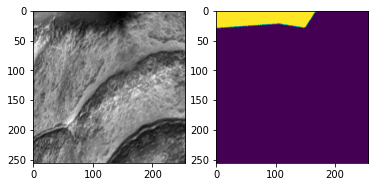

In [ ]:
x = image_generator.next() 
y = mask_generator.next() 
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

ParÂmetros modelo

In [ ]:
#Parâmetros usados em todos modelos
n_classes = 3
activation = 'softmax'
INPUT_SHAPE = (X_train.shape[1],X_train.shape[2],X_train.shape[3])

LR = 0.0001
optim = tensorflow.keras.optimizers.Adam(LR)

# Segmentation models losses
dice_loss = sm.losses.DiceLoss(class_weights = ([0.25,0.25,0.5]))
#dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1*focal_loss)

# Métricas
#metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
metrics = ['acc', sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), sm.metrics.Precision(threshold=0.5), sm.metrics.Recall(threshold=0.5)]

Adicionar checkpoints, ES e Log

In [ ]:
#Add checkpoints 
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
#filepath='saved_models/models.h5'
filepath=('/content/drive/MyDrive/DB_mosca_minadora/models_es_logs/UNET_densenet121_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5') #File name includes epoch and validation accuracy.

checkpoint = ModelCheckpoint(filepath, monitor='val_iou_score', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_iou_score', patience=5, verbose=1)

log_csv = CSVLogger ('/content/drive/MyDrive/DB_mosca_minadora/logs/UNET_densenet121.csv', separator = ',', append=False)

callbacks_list = [checkpoint, early_stop, log_csv]

Backbone



In [ ]:
BACKBONE = 'vgg16' #'vgg16','resnet34','inceptionv3', 'densenet121'
preprocess_input = sm.get_preprocessing(BACKBONE)

#preprocess input
#X_train_processed = preprocess_input(X_train)
#X_test_processed = preprocess_input(X_val) #X_test

Modelo U-Net

In [ ]:
#from tensorflow.keras.utils import get_file
# Definir modelo 
model = sm.Unet(BACKBONE, input_shape=INPUT_SHAPE, encoder_weights='imagenet', classes=n_classes, activation=activation)

# Compile Keras model with defined optimizer, loss and metrics
model.compile(optim,total_loss,metrics=metrics)

print(model.summary())

Modelo FPN

In [ ]:
#from tensorflow.keras.utils import get_file
# Definir modelo 
model = sm.FPN(BACKBONE, input_shape=INPUT_SHAPE, encoder_weights='imagenet', classes=n_classes, activation=activation)

# Compile Keras model with defined optimizer, loss and metrics
model.compile(optim,total_loss,metrics=metrics)

print(model.summary())

Modelo LinkNet

In [ ]:
#from tensorflow.keras.utils import get_file
# Definir modelo 
model = sm.Linknet(BACKBONE, input_shape=INPUT_SHAPE, encoder_weights='imagenet', classes=n_classes, activation=activation)

# Compile Keras model with defined optimizer, loss and metrics
model.compile(optim,total_loss,metrics=metrics)

print(model.summary())

## Ajustar modelo

In [ ]:
# Sem augmentação
history=model.fit(X_train_processed, 
          y_train_cat,
          batch_size=16, 
          epochs=50,
          verbose=1,
          validation_data=(X_test_processed, y_test_cat))


In [ ]:
# Com augmentação 50 épocas
history = model.fit_generator(my_generator, validation_data=validation_datagen, steps_per_epoch=50, validation_steps=50, epochs=50)


In [ ]:
# Com augmentação e 30 épocas, callbacks_list
history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=len(X_train) // 16, validation_steps=len(X_train) // 16, epochs=30, callbacks = callbacks_list)

In [ ]:
# Com augmentação 50 épocas callbacks_list
history = model.fit_generator(my_generator, validation_data=validation_datagen, steps_per_epoch=50, validation_steps=50, epochs=50, callbacks = callbacks_list)


In [ ]:
# Com augmentação e 30 épocas
history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=len(X_train) // 16, validation_steps=len(X_train) // 16, epochs=30)


## Salvar modelo

In [ ]:
model.save('/content/drive/MyDrive/DB_mosca_minadora/models/UNET_30_epochs_resnet34_uint8_ES.hdf5')
model.save('/content/drive/MyDrive/DB_mosca_minadora/models/LINKNET_30_epochs_resnet34_uint8_ES.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Salvar resultados

In [ ]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = '/content/drive/MyDrive/DB_mosca_minadora/history/history_LINKNET_30_epochs_resnet34_uint8_ES.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = '/content/drive/MyDrive/DB_mosca_minadora/history/history_LINKNET_30_epochs_resnet34_uint8_ES.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Importar modelo

In [ ]:
from keras.models import load_model

#Set compile=False as we are not loading it for training, only for prediction.
model = load_model('/content/drive/MyDrive/DB_mosca_minadora/models/UNET_30_epochs_resnet34_uint8.h5', compile=False)

## Métricas de avaliação

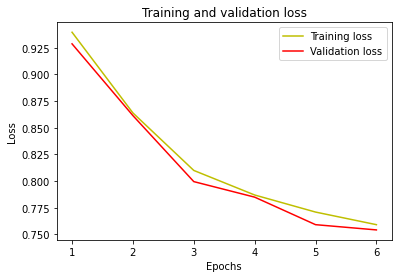

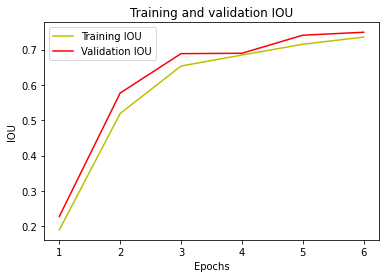

In [ ]:
#com segmentation_models
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/content/drive/MyDrive/DB_mosca_minadora/graphs/training_loss_LINKNET_30_epochs_resnet34_uint8_ES.png")
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.savefig("/content/drive/MyDrive/DB_mosca_minadora/graphs/training_iou_LINKNET_30_epochs_resnet34_uint8_ES.png")
plt.show()

In [ ]:
plt.plot(history.history['iou_score'])
plt.plot(history.history['f1-score'])
plt.plot(history.history['loss'])
plt.plot(history.history['precision'])
plt.plot(history.history['recall'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_iou_score'])
plt.plot(history.history['val_f1-score'])
plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.plot(history.history['acc'])

## IOU

In [ ]:
#com segmentation_models
y_pred=model.predict(X_val) #X_test_processed
y_pred_argmax=np.argmax(y_pred, axis=3)

In [ ]:
#com segmentation_models
from keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_val[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.76443785


IOU para cada classe

In [ ]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0])
print("IoU for class1 is: ", class1_IoU)
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[0,1]+ values[2,1])
print("IoU for class2 is: ", class2_IoU)
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[0,2]+ values[1,2])
print("IoU for class3 is: ", class3_IoU)

[[3.929018e+06 3.782440e+05 1.645000e+03]
 [3.129010e+05 5.528168e+06 6.138200e+04]
 [1.823700e+04 1.400590e+05 3.127140e+05]]
IoU for class1 is:  0.8467629
IoU for class2 is:  0.86098427
IoU for class3 is:  0.58556616


## Fazer predição para algumas imagens

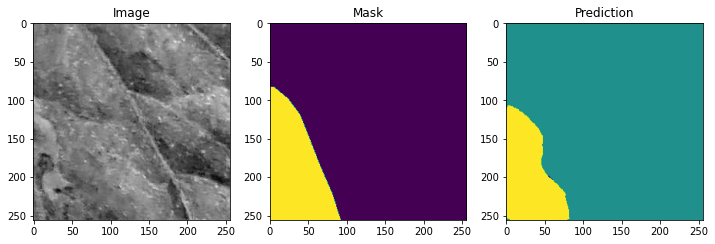

In [ ]:
#com segmentation_models
import random
img_number = random.randint(0, len(X_val)-1)#X_test_processed - test_images
img = X_val[img_number] # test_images
mask = y_val[img_number] #test_masks
prediction = y_pred_argmax[img_number]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(img[:,:,0],cmap='gray')
plt.subplot(232)
plt.title('Mask')
plt.imshow(mask[:,:,0])
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction)
plt.show()

## Métricas e predição nas imagens de TESTE

In [ ]:
	# evaluate model
_, acc = model.evaluate(X_val, y_val)
print("Accuracy = ", (acc * 100.0), "%")

In [ ]:
#com segmentation_models
y_pred=model.predict(test_images) #X_test_processed
y_pred_argmax=np.argmax(y_pred, axis=3)

In [ ]:
# IOU = true_positive / (true_positive + false_positive + false_negative).
from keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_masks_input[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7661516


In [ ]:
#IOU for each class is..
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0])
print("IoU for class1 is: ", class1_IoU)
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[0,1]+ values[2,1])
print("IoU for class2 is: ", class2_IoU)
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[0,2]+ values[1,2])
print("IoU for class3 is: ", class3_IoU)

[[ 6293281.   923271.    50028.]
 [  312042. 10859089.   112109.]
 [   25982.   410311.   936831.]]
IoU for class1 is:  0.827562
IoU for class2 is:  0.8606834
IoU for class3 is:  0.6102096


In [ ]:
np.unique(values[2])

array([ 25982., 410311., 936831.], dtype=float32)

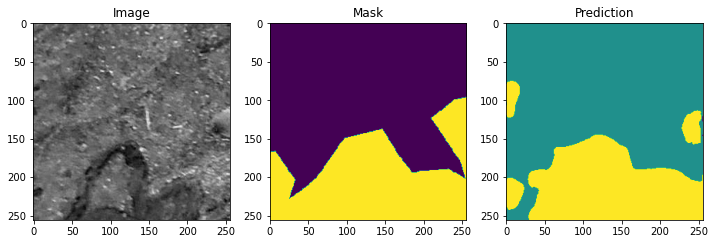

In [ ]:
#com segmentation_models
import random
img_number = random.randint(0, len(test_images))#X_test_processed - test_images
img = test_images[img_number] # test_images
mask = test_masks_input[img_number] #test_masks #y_test_cat
prediction = y_pred_argmax[img_number]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(img[:,:,0],cmap='gray')
plt.subplot(232)
plt.title('Mask')
plt.imshow(mask[:,:,0])
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction)
plt.show()

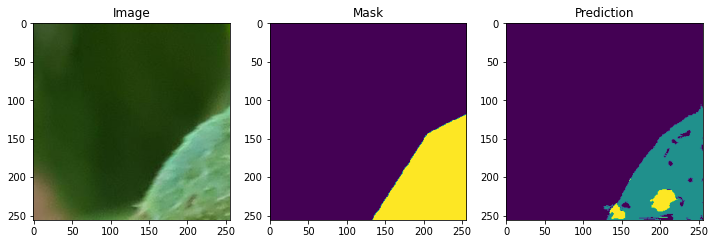

In [ ]:
test_img_dir = '/content/drive/MyDrive/DB_mosca_minadora/test/test_images_patches_filtrado/'
test_mask_dir = '/content/drive/MyDrive/DB_mosca_minadora/test/test_masks_patches_filtrado/'

img_list = os.listdir(test_img_dir)
msk_list = os.listdir(test_mask_dir)
img_list.sort()
msk_list.sort()
num_images = len(os.listdir(test_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(test_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(test_mask_dir+msk_list[img_num], 1)
prediction = y_pred_argmax[img_num]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(img_for_plot)
plt.subplot(232)
plt.title('Mask')
plt.imshow(mask_for_plot[:,:,0])
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction)
plt.imsave('/content/drive/MyDrive/DB_mosca_minadora/pred_texto/unet_vgg16/'+str(img_num)+".png", prediction.astype(np.uint8)) #, cmap='gray'
plt.show()

certo para salvar imagem original, sem plotar

In [ ]:
import numpy as np
import cv2
import os
import glob

#Process each patch in test database
img_number = 1
for image in range(test_images.shape[0]):
    input_img = [test_images] #image dá erro #(test_images) #np.array(test_images)  # [test_images]roda mais nao salva
    y_pred = model.predict(input_img)
    y_pred_argmax=np.argmax(y_pred, axis=3)
    prediction = y_pred_argmax[image]
    img_number +=1
    cv2.imwrite('/content/drive/MyDrive/DB_mosca_minadora/predicted_masks/unet_resnet34_5/'+str(img_number)+".png", prediction.astype(np.uint8)) #prediciton 

certo pra salvar plotagem

In [ ]:
import numpy as np
import cv2
import os
import glob

#Process each patch in test database
img_number = 1
for image in range(test_images.shape[0]):
    input_img = [test_images] #image dá erro #(test_images) #np.array(test_images)  # [test_images]roda mais nao salva
    y_pred = model.predict(input_img)
    y_pred_argmax=np.argmax(y_pred, axis=3)
    prediction = y_pred_argmax[image]
    img_number +=1
    
    plt.figure(figsize=(12, 8))    
    plt.imshow(prediction)
    plt.imsave('/content/drive/MyDrive/DB_mosca_minadora/pred_texto/fpn_densenet121_2/'+str(img_number)+".png", prediction.astype(np.uint8)) #, cmap='gray'
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

reconstruir patches da mesma maneira que fiz pra cortar , ao inves de crop é outra oisa..... descobrir

In [ ]:
import os
import glob
from PIL import Image
Image.MAX_IMAGE_PIXELS = None # to avoid image size warning

#%%

imgdir = '/content/drive/MyDrive/BD_filtred/test_images_patches/'
filelist = [f for f in glob.glob(imgdir + "**/*.png", recursive=True)]
savedir = '/content/drive/MyDrive/BD_filtred/reconstructed/'

start_pos = start_x, start_y = (0, 0)
crop_image_size = w, h = (2048,3840) #(256,256) #(2048,3840) tamanho original
new_img = Image.new('reconstructed', crop_image_size)

for file in filelist:
    img = Image.open(file)
    width, height = img.size

    frame_num = 1
    for col_i in range(0, width, w):
        for row_i in range(0, height, h):
            crop = img.blend((col_i, row_i, col_i + w, row_i + h))
            name = os.path.basename(file)
            name = os.path.splitext(name)[0]
            save_to= os.path.join(savedir, name+"_{:03}.png")
            crop.save(save_to.format(frame_num))
            frame_num += 1

In [ ]:
from PIL import Image
import glob

image_list = []
for filename in glob.glob('/content/drive/MyDrive/BD_filtred/test_images_patches/'): 
    print(filename)
    im=Image.open(filename)
    image_list.append(im)

In [ ]:
import os
from PIL import Image

def get_offsets(file):
	return [int(dimension[1:]) for dimension in file.split('.')[2:4]]

# Get the list of files
files = [file for file in sorted(os.listdir('.')) if file.startswith('Train.')]

if not files:
	print("No input files found")
else:
	print(str(len(files))+" input files found")
	lastFile = files[-1]
	outfile = lastFile[len('Train.'):].split('.')[0]+'_new.tif'

	# The width and height of the original image can be determined from the last tile
	with Image.open(lastFile) as lastIm:
		w, h = lastIm.size
	x, y = get_offsets(lastFile)
	w += x
	h += y
	print("Combined image should be "+str(w)+" by "+str(h))
	
	# Create the new image
	im_out = Image.new(lastIm.mode, (w, h))
	for file in files:
		x, y = get_offsets(file)
		
		# Paste each tile
		with Image.open(file) as im:
			im_out.paste(im, (x, y))
	im_out.save(outfile)
	print("Image saved as "+outfile)

Severidade

In [ ]:
#test_masks_input = np.expand_dims(test_masks, axis=3)
print ("Train Image data shape:", test_masks_input.shape)
print ("Max pixel valeue in test mask:", test_masks_input.max())
print ("Labels in test masks:", np.unique(test_masks_input))


Train Image data shape: (304, 256, 256, 1, 1, 1)
Max pixel valeue in test mask: 75
Labels in test masks: [ 0 38 75]


In [ ]:
predicted_masks_names = glob.glob('/content/drive/MyDrive/DB_mosca_minadora/predicted_masks/unet_inceptionv3/*.png')
predicted_masks_names.sort()
predicted_masks = [cv2.imread(mask,0) for mask in predicted_masks_names]
predicted_masks = np.array(predicted_masks)

In [ ]:
print ("Train Image data shape:", predicted_masks.shape)
print ("Max pixel valeue in test mask:", predicted_masks.max())
print ("Labels in test masks:", np.unique(predicted_masks))

Train Image data shape: (304, 256, 256)
Max pixel valeue in test mask: 2
Labels in test masks: [0 1 2]


In [ ]:
classe_1 = predicted_masks[:,:,0]
classe_2 = predicted_masks[:,:,1]
classe_3 = predicted_masks[:,:,2]
print(np.sum(classe_1))
print(np.sum(classe_2))
print(np.sum(classe_3))

52669
53098
54925


Estimativa automática da severidade para as máscaras preditas

In [ ]:
predicted_masks_names = glob.glob('/content/drive/MyDrive/DB_mosca_minadora/predicted_masks/unet_resnet34/*.png')
predicted_masks_names.sort()
predicted_masks = [cv2.imread(mask,0) for mask in predicted_masks_names]
predicted_masks = np.array(predicted_masks)
for mask in range (len(predicted_masks)):
  classe_2 = predicted_masks[:,:,1] 
  classe_3 = predicted_masks[:,:,2]
  lesao = np.sum(classe_3)
  folha = np.sum(classe_2) + lesao
  severity = (lesao/folha)*100
  severity = round(severity,2)
  print(severity)

In [ ]:
df = pd.DataFrame(columns=['mask', 'soma_folha', 'soma_sintoma', 'soma_fundo', 'severidade'])

predicted_masks_names = glob.glob('/content/drive/MyDrive/DB_mosca_minadora/predicted_masks/unet_resnet34_5/*.png')
predicted_masks_names.sort()
predicted_masks = [cv2.imread(mask,0) for mask in predicted_masks_names]
predicted_masks = np.array(predicted_masks)
for mask in range (len(predicted_masks)):
  folha = np.where(predicted_masks [mask,:,:] == 1 , 1, 0) #folha
  soma_folha = np.sum(folha)
  sintoma = np.where(predicted_masks [mask,:,:] == 2 , 1, 0)
  soma_sintoma = np.sum(sintoma)
  fundo = np.where(predicted_masks [mask,:,:] == 0 , 1, 0)
  soma_fundo = np.sum(fundo)
  severidade = (soma_sintoma/(soma_folha+soma_sintoma))*100
  severidade = round(severidade,2)
  print(soma_fundo, soma_folha, soma_sintoma, severidade)
  
  d = {'mask': mask, 'soma_folha':soma_folha, 'soma_sintoma':soma_sintoma, 'soma_fundo':soma_fundo, 'severidade': severidade}
  new_df = pd.DataFrame([d])
  df = pd.concat([df, new_df])
  df.to_csv('/content/drive/MyDrive/DB_mosca_minadora/pred_csv/pred_unet_resnet34_5.csv', index=False)

24 65512 0 0.0
30081 16025 19430 54.8
24133 41403 0 0.0
62587 2949 0 0.0
15299 50237 0 0.0
12123 46180 7233 13.54
49110 15249 1177 7.17
36037 29499 0 0.0
3246 62290 0 0.0
7203 57162 1171 2.01
49627 15909 0 0.0
255 42890 22391 34.3
62770 2766 0 0.0
53528 12008 0 0.0
48433 17103 0 0.0
19366 46170 0 0.0
15774 49762 0 0.0
28741 36795 0 0.0
45179 20357 0 0.0
53779 11757 0 0.0
57151 8385 0 0.0
34579 6227 24730 79.89
521 54929 10086 15.51
32147 17858 15531 46.52
43375 14554 7607 34.33
58994 6542 0 0.0
38960 26576 0 0.0
2470 63066 0 0.0
0 61904 3632 5.54
0 46617 18919 28.87
0 56313 9223 14.07
1058 64478 0 0.0
22174 43362 0 0.0
9428 56083 25 0.04
37518 28018 0 0.0
42967 22569 0 0.0
7793 57743 0 0.0
0 55449 10087 15.39
0 65536 0 0.0
33421 31423 692 2.15
4821 60715 0 0.0
33393 32143 0 0.0
57963 7573 0 0.0
1373 64163 0 0.0
38488 27048 0 0.0
0 47438 18098 27.62
4859 60677 0 0.0
36762 23967 4807 16.71
56892 8644 0 0.0
28380 37156 0 0.0
13757 47730 4049 7.82
15109 47788 2639 5.23
21608 43928 0 0.0
55

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


0 61568 3968 6.05
0 64444 1092 1.67
3806 41487 20243 32.79
39069 26467 0 0.0
11043 54493 0 0.0
0 65533 3 0.0
31174 34362 0 0.0
10639 54897 0 0.0
46501 19035 0 0.0
60056 5355 125 2.28
61593 3943 0 0.0
40653 24883 0 0.0
23128 41539 869 2.05
25337 40199 0 0.0
43689 21847 0 0.0
58548 6988 0 0.0
23308 42228 0 0.0
2040 56756 6740 10.61
8748 56578 210 0.37
10875 54235 426 0.78
21217 44319 0 0.0
43537 21599 400 1.82
13178 52358 0 0.0
407 65063 66 0.1
9308 55994 234 0.42
39126 22399 4011 15.19
16462 49074 0 0.0
13995 51541 0 0.0
25160 37559 2817 6.98
2060 63476 0 0.0
1230 59761 4545 7.07
0 36769 28767 43.89
30441 13495 21600 61.55
51937 3092 10507 77.26
55191 10345 0 0.0
366 65170 0 0.0
10574 49277 5685 10.34
11748 51228 2560 4.76
45483 13294 6759 33.71
41490 23824 222 0.92
48298 17238 0 0.0
1302 64234 0 0.0
10172 55364 0 0.0
33853 31683 0 0.0
60943 2833 1760 38.32
47136 18398 2 0.01
28672 36864 0 0.0
23437 42099 0 0.0
33117 32419 0 0.0
47462 18074 0 0.0
36814 25838 2884 10.04
63117 2419 0 0.0


Severidade para mascaras de teste

In [ ]:
df = pd.DataFrame(columns=['mask', 'soma_folha', 'soma_sintoma', 'soma_fundo', 'severidade'])

test_masks_names = glob.glob('/content/drive/MyDrive/DB_mosca_minadora/test/test_masks_patches_filtrado/*.png')
test_masks_names.sort()
test_masks = [cv2.imread(mask,0) for mask in test_masks_names]
test_masks = np.array(test_masks)
for mask in range (len(predicted_masks)):
  folha = np.where(predicted_masks [mask,:,:] == 1 , 1, 0)
  soma_folha = np.sum(folha)
  sintoma = np.where(predicted_masks [mask,:,:] == 2 , 1, 0)
  soma_sintoma = np.sum(sintoma)
  fundo = np.where(predicted_masks [mask,:,:] == 0 , 1, 0)
  soma_fundo = np.sum(fundo)
  #print(soma_fundo, soma_folha, soma_sintoma)
  severidade = (soma_sintoma/(soma_folha+soma_sintoma))*100
  severidade = round(severidade,2)
  print(soma_fundo, soma_folha, soma_sintoma, severidade)
  
  d = {'mask': mask, 'soma_folha':soma_folha, 'soma_sintoma':soma_sintoma, 'soma_fundo':soma_fundo, 'severidade': severidade}
  new_df = pd.DataFrame([d])
  df = pd.concat([df, new_df])
  df.to_csv('/content/drive/MyDrive/DB_mosca_minadora/pred_csv/pred_test_db_anotated_certo.csv', index=False)

4780 60756 0 0.0
28479 7939 29118 78.58
42498 23038 0 0.0
61842 3694 0 0.0
15153 50383 0 0.0
8 46954 18574 28.35
48687 14008 2841 16.86
49829 15707 0 0.0
3498 62038 0 0.0
8322 46607 10607 18.54
30475 34513 548 1.56
4693 39671 21172 34.8
63026 2510 0 0.0
58246 7290 0 0.0
44080 21456 0 0.0
19827 45709 0 0.0
15521 50015 0 0.0
28757 36779 0 0.0
39279 26257 0 0.0
53587 11949 0 0.0
56412 9124 0 0.0
34446 7942 23148 74.45
1336 54696 9504 14.8
31219 18938 15379 44.81
42596 14064 8876 38.69
58234 7302 0 0.0
38254 27282 0 0.0
1935 63601 0 0.0
1 62568 2967 4.53
0 47090 18446 28.15
1 56315 9220 14.07
655 64881 0 0.0
21433 44103 0 0.0
10419 55053 64 0.12
36412 28698 426 1.46
42008 22546 982 4.17
7432 58104 0 0.0
0 56606 8930 13.63
9 49122 16405 25.04
32718 32167 651 1.98
4575 60961 0 0.0
32795 32414 327 1.0
55993 9543 0 0.0
2131 63405 0 0.0
37596 27940 0 0.0
1 50111 15424 23.54
4717 60819 0 0.0
35658 26985 2893 9.68
54121 11415 0 0.0
27662 37874 0 0.0
14090 49191 2255 4.38
13564 49672 2300 4.43
310